In [132]:
import arrow
import json
import pandas as pd
import numpy as np
import requests

%matplotlib inline 
import matplotlib.pyplot as plt

In [133]:
endpoint = 'http://localhost:8000'
country_codes = ['DK', 'ES', 'FR']
bounding_boxes = {
    'DK': [
        [13.30324, 57.751949], # NE
        [7.60472, 54.509132], # SW
    ],
    'ES': [
        [4.32788, 43.789959],
        [-18.160789, 27.63546]
    ],
    'PT': [
        [-6.18931, 42.154121],
        [-9.5, 37]
    ]
}
start, end = [
    arrow.get(2016, 11, 1),
    arrow.get(2016, 12, 1)
]
time_span = map(lambda o: o[0], arrow.Arrow.span_range('hour', start, end))

In [134]:
r = requests.session()

In [135]:
def fetch_production(country_code, t):
    url = '%s/v1/production' % endpoint
    params = {
        'countryCode': country_code,
        'datetime': t.to('utc').isoformat()
    }
    obj = r.get(url, params=params).json()
    if not obj: return
    return obj if (t - arrow.get(obj['datetime'])).total_seconds() < 3600 else None
print time_span[0], fetch_production(country_codes[0], time_span[0])

2016-11-01T00:00:00+00:00 None


In [136]:
# Fetch all country production data
dates = map(lambda t: pd.Timestamp(t.datetime), time_span)
df_wind = pd.DataFrame(np.zeros((len(time_span), len(country_codes)))*np.nan, index=dates, columns=country_codes)
df_solar = pd.DataFrame(np.zeros((len(time_span), len(country_codes)))*np.nan, index=dates, columns=country_codes)

for country_code in country_codes:
    print 'Fetching %s..' % country_code
    for t in time_span:
        o = fetch_production(country_code, t)
        if not o: continue
        t = arrow.get(o['datetime']).datetime
        if o.get('production', {}).get('wind', None) is not None:
            df_wind.loc[t, country_code] = o['production']['wind']
        if o.get('production', {}).get('solar', None) is not None:
            df_solar.loc[t, country_code] = o['production']['solar']
# TODO: write in a cache

Fetching DK..
Fetching ES..
Fetching FR..


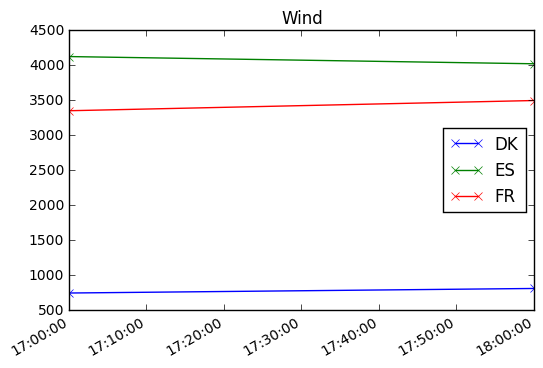

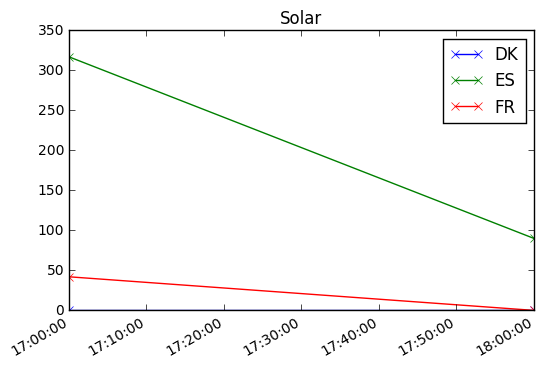

In [137]:
df_wind.dropna().plot(marker='x', title='Wind')
df_solar.dropna().plot(marker='x', title='Solar')

In [138]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from feeder.parsers import wind, solar

# Force a reload
reload(wind)
reload(solar)

def fetch_best_forecast(t):
    obj = wind.fetch_wind(r, t, compress=False)
    # Interpolate
    # ...
    return obj

def get_wind_measurements(country_code, wind_grid):
    # Return list of wind measurements inside the country
    pass

In [139]:
obj = fetch_best_forecast(arrow.now())

Fetching forecast of 2016-11-25T15:00:00+01:00 made at 2016-11-25T12:00:00+01:00
Fetching forecast of 2016-11-25T18:00:00+01:00 made at 2016-11-25T12:00:00+01:00
Done


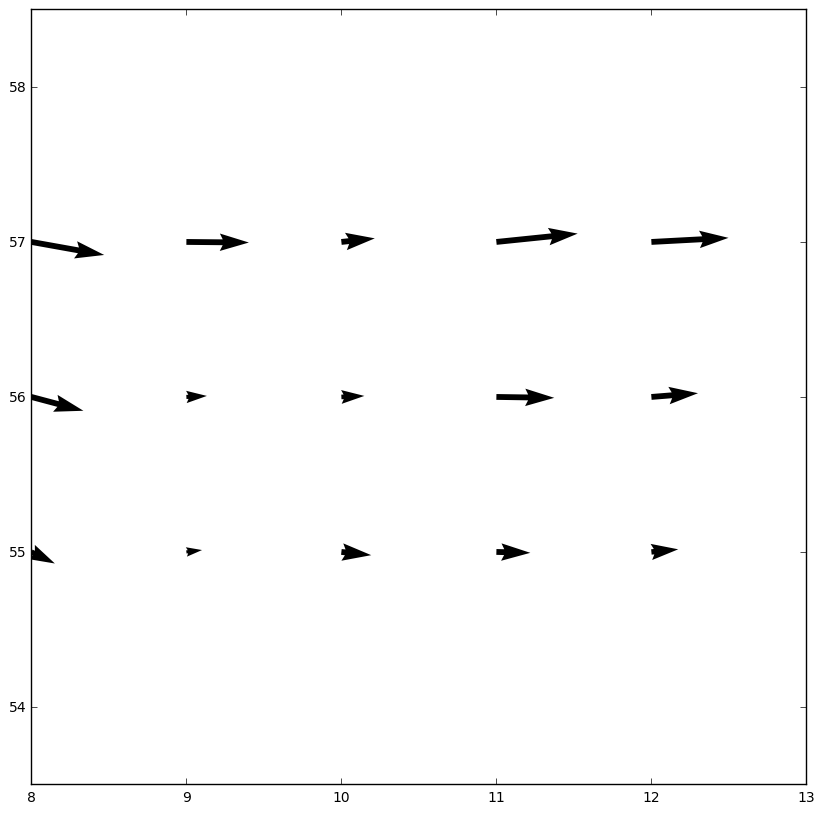

In [140]:
header_before = obj['forecasts'][0][0]['header']
header_after  = obj['forecasts'][1][0]['header']
t_before = arrow.get(header_before['refTime']).replace(hours=+header_before['forecastTime'])
t_after  = arrow.get( header_after['refTime']).replace(hours=+header_after['forecastTime'])

now = arrow.utcnow()

grid_origin = [header_before['lo1'], header_before['la1']]
grid_delta = [header_before['dx'], header_before['dy']]
grid_n = [header_before['nx'], header_before['ny']]

dk_temp_data_u = []
dk_temp_data_v = []
lons = [] # TEMP, will be removeable
lats = [] # TEMP, will be removeable
country_code = 'DK'
bb = bounding_boxes[country_code]

for i in range(grid_n[0]):
    for j in range(grid_n[1]):
        lon = grid_origin[0] + i * grid_delta[0]
        if lon > 180: lon -= 360
        lat = grid_origin[1] - j * grid_delta[1]
        p = j * grid_n[0] + i
        if lon <= bb[0][0] and lat <= bb[0][1] and \
            lon >= bb[1][0] and lat >= bb[1][1]:
            # We're in the box!
            x = (now.timestamp - t_before.timestamp)/(t_after.timestamp - t_before.timestamp)
            lons.append(lon)
            lats.append(lat)
            dk_temp_data_u.append(obj['forecasts'][0][0]['data'][p] * (1-x) + obj['forecasts'][1][0]['data'][p] * x)
            dk_temp_data_v.append(obj['forecasts'][0][1]['data'][p] * (1-x) + obj['forecasts'][1][1]['data'][p] * x)
        

plt.figure(figsize=(10,10))
plt.quiver(lons, lats, dk_temp_data_u, dk_temp_data_v)
plt.axis('equal');